## Name: KO KO WIN

In [ ]:
from time import sleep
from kafka import KafkaConsumer 
import datetime as dt 
import matplotlib.pyplot as plt
import folium
%matplotlib notebook 

## Task 2.1 
### Streaming Data Visualization

#### Please load the Producer 1 to see the min-max result

<IPython.core.display.Javascript object>


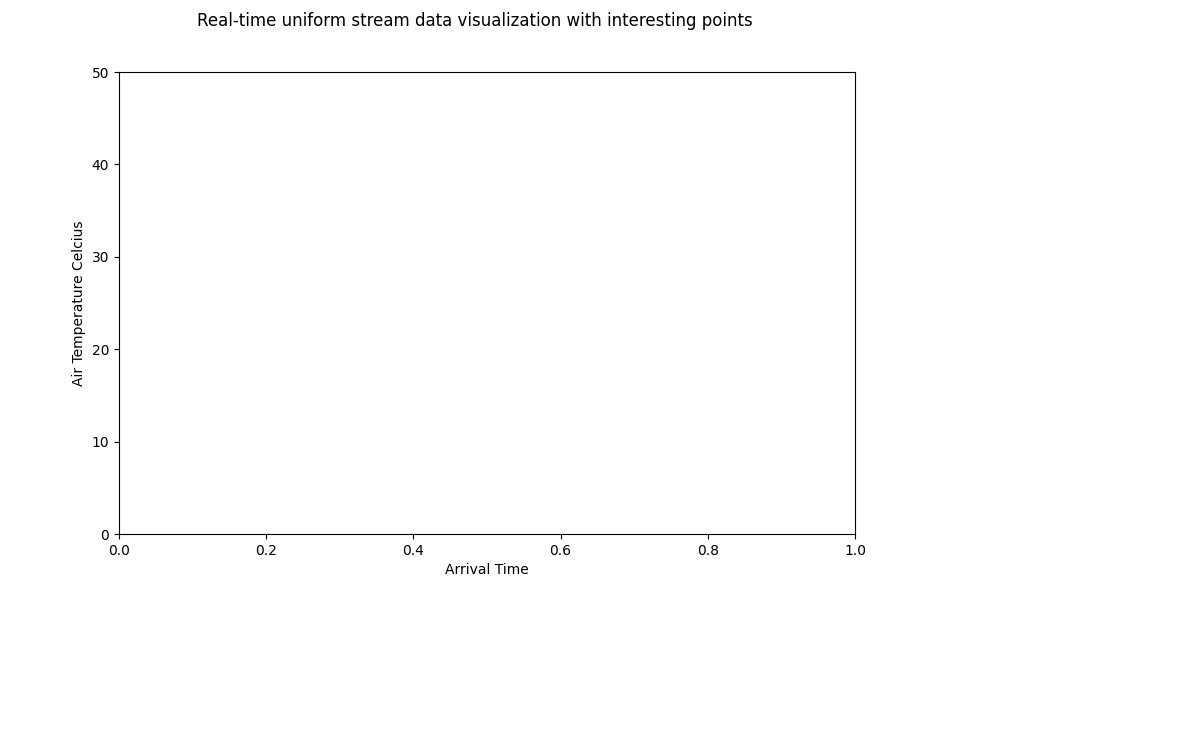

In [5]:
topic = "Producer01"

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer


def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Real-time uniform stream data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature Celcius')
        ax.set_ylim(0,50) 
        ax.set_yticks([0,10,20,30,40,50])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

        
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            data = eval(data)
            #print(data)
        
            if data["producer_information"] == "Event Producer 1 (Climate)":
                x.append(data["time"]) 
                y.append(data["air_temperature_celcius"])
                #print("x:", x)
                #print("y:", y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air Temperature Celcius')
                ax.set_ylim(0,50) 
                ax.set_yticks([0,10,20,30,40,50])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))

        
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## Task 2.2 
### Static Data Visualization

#### Remark: I have created a mock database for this task as per the tutor Sir Shageenderan since i could not successfully obtain the result for the streaming application. The reason for the mock database is to demonstrate that i can answer the task 2.2 correctly if i obtain the correct result for the streaming application. I have coded both questions to the best of my ability and i can ensure it will works completely fine with the correct output from streaming application

#### 2.2a)

In [6]:
from pymongo import MongoClient
from pprint import pprint

In [7]:
client = MongoClient()
db = client.fit3182_assignment_db
coll = db.mock

In [8]:
coll.drop()

In [9]:
#create a mock data for the plot
myDict = [
    {"GHI_w/m2": 145, "air_temperatire_celcius" : 20, "fire" : [
    {"hour" : 12},
    {"hour" : 2},
    {"hour" : 12},
    {"hour" : 3},
    {"hour" : 13},
    {"hour" : 16},
    {"hour" : 12},
    {"hour" : 12},
    {"hour" : 12},
    {"hour" : 3},
    {"hour" : 17},
    {"hour" : 17},
    {"hour" : 21},
    {"hour" : 21},
    {"hour" : 8},
    {"hour" : 17},
    {"hour" : 8},
    {"hour" : 8},
    {"hour" : 12},
    {"hour" : 3},
    {"hour" : 17},
]}, 
    {"GHI_w/m2": 120, "air_temperatire_celcius" : 10}, 
    {"GHI_w/m2": 167, "air_temperatire_celcius" : 21}, 
    {"GHI_w/m2": 89, "air_temperatire_celcius" : 16}, 
    {"GHI_w/m2": 134, "air_temperatire_celcius" : 12}, 
    
] 

x = coll.insert_many(myDict)

pprint(coll.find_one({"GHI_w/m2": 145}))

{'GHI_w/m2': 145,
 '_id': ObjectId('628a23cc37fa16b7a9c81ebe'),
 'air_temperatire_celcius': 20,
 'fire': [{'hour': 12},
          {'hour': 2},
          {'hour': 12},
          {'hour': 3},
          {'hour': 13},
          {'hour': 16},
          {'hour': 12},
          {'hour': 12},
          {'hour': 12},
          {'hour': 3},
          {'hour': 17},
          {'hour': 17},
          {'hour': 21},
          {'hour': 21},
          {'hour': 8},
          {'hour': 17},
          {'hour': 8},
          {'hour': 8},
          {'hour': 12},
          {'hour': 3},
          {'hour': 17}]}


<IPython.core.display.Javascript object>


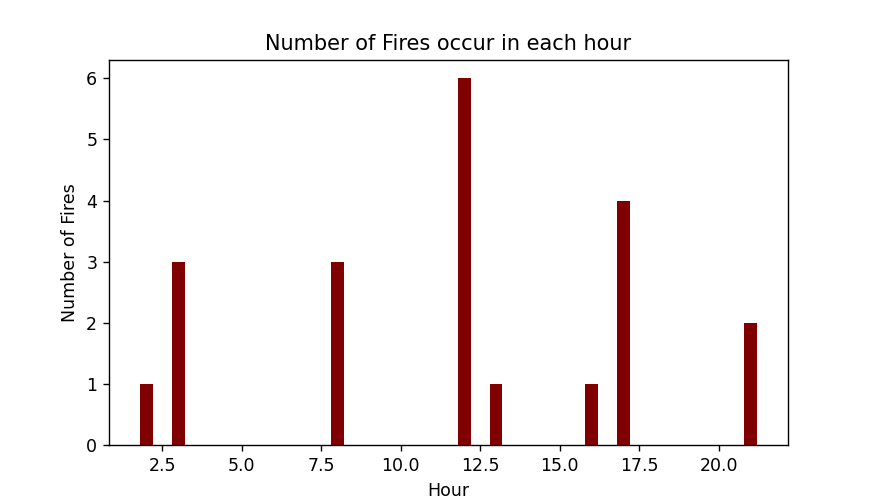

In [10]:
#count number of fire for each hour
results = coll.aggregate([{'$unwind' : '$fire'}, 
                         {"$group":{"_id": "$fire.hour", "count":{"$sum" :1}}}])

#add the hour to x axis array and add the count of fire to y axis
x , y = [], []
for res in results: 
    x.append(res["_id"])
    y.append(res["count"])

#visualise the result 
plt.figure(figsize=(7,4))
plt.bar(x, y, color = "maroon", width = 0.4)
plt.xlabel("Hour")
plt.ylabel("Number of Fires")
plt.title("Number of Fires occur in each hour")
plt.show()

#### 2.2b) 

In [11]:
client = MongoClient()
db = client.fit3182_assignment_db
coll = db.mapfol

In [12]:
myDocs = [
    {"GHI_w/m2": 145}, 
    {"fire" : [
        {"cause" : "natural",
         "cause": "natural",
         "cause": "other"}]},
    
    {"hotspots": [
        {"latitude": -34.2685,
        'longitude' : 142.2025,
        "surface_temperaure_celcius" : 59,
        "confidence" : 80,
        "air_temperature_celcius" : 20,
        "relative_humidity" : 48.3}, 
        
        {"latitude": -38.0423,
        'longitude' : 146.4048,
        "surface_temperaure_celcius" : 17,
        "confidence" : 84,
        "air_temperature_celcius" : 32,
        "relative_humidity" : 49.9}, 
        
        {"latitude": -37.7783,
        'longitude' : 146.6649,
        "surface_temperaure_celcius" : 9,
        "confidence" : 85,
        "air_temperature_celcius" : 40,
        "relative_humidity" : 41.2}
    ]}
        
]

In [13]:
x= coll.insert_many(myDocs)

pprint(coll.find_one({"GHI_w/m2": 145}))

{'GHI_w/m2': 145, '_id': ObjectId('628a203ab28d4e34e618639b')}


In [24]:
results = coll.aggregate([{"$unwind": "$hotspots"}])

res = coll.aggregate([{"$unwind": "$fire"}])

#Initialise map at Melbourne 
fomap = folium.Map(location=[-37.8120, 144.9515], zoom_start=5)


for record in results: 
    lat = record["hotspots"]["latitude"] #get latitude info
    lon = record["hotspots"]["longitude"] #get longitude info
    
    for i in res: 
        cause = i["fire"]["cause"] #get cause of fire
    
    sf_tc = str(record["hotspots"]["surface_temperaure_celcius"]) #get surface temperature info 
    air_tc = str(record["hotspots"]["air_temperature_celcius"]) #get air temperature info
    humidity = str(record["hotspots"]["relative_humidity"]) #get the relative humidity
    confidence = str(record["hotspots"]["confidence"]) #get the confidence
        
    popup_msg = "Air Temperature is: {}\n Surface Temperature is: {}\n Relative Humidity is: {}\n Confidence is: {}".format(air_tc, sf_tc, humidity, confidence)
    
    if cause == "other": 
        folium.Marker(
            [lat, lon], 
            popup = folium.Popup(popup_msg), 
            icon = folium.Icon(color="red")
        ).add_to(fomap)
    else: 
        folium.Marker(
            [lat, lon], 
            popup = folium.Popup(popup_msg),
            icon = folium.Icon(color="blue")
        
        ).add_to(fomap)

fomap